## Инициализация, загрузка данных, первичная обработка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.markers
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

path = 'C:\\Users\\Xiaomi\\Desktop\\Playrix\\'
purchases = pd.read_csv(path+'purchases.csv', names=['id', 'buy_time', 'revenue'])
users = pd.read_csv(path+'users.csv', names=['id', 'reg_time', 'feature_x','cpi'])

In [2]:
purchases.head(2)

,id,buy_time,revenue
0,3d41f57091f8653de23efb8e60ec8dd2,2020-08-22 10:03:53,0.867115
1,5af8d40efe885ac79ccc6b5a3f2da36e,2020-08-22 10:05:04,2.117543


In [3]:
users.head(2)

,id,reg_time,feature_x,cpi
0,a1f3165713e2609ccfa94ac152745de9,2020-08-10 16:13:40,B10,0.68
1,65b3c06b73746ce96c985b2de163cb30,2020-08-10 16:14:11,B0,11.45


In [4]:
def toDate(df, col):
    # устанавливает дату в днях
    # выполняется несколько минут!
    df[col+'_date'] = (df[col].apply(pd.to_datetime)).dt.date
    
    return df
    
purchases = toDate(purchases, 'buy_time')
users = toDate(users, 'reg_time')  

print(purchases.columns, users.columns, sep='\n')

Index(['id', 'buy_time', 'revenue', 'buy_time_date'], dtype='object')
Index(['id', 'reg_time', 'feature_x', 'cpi', 'reg_time_date'], dtype='object')


## Анализ сегментов

In [5]:
def countSegment(df):
    # информация о кол-ве стоимостей и клиентов в разрезе сегментов
    
    for i in users['feature_x'].unique():
        df1 = df[df['feature_x'] == i]
        consumers = df1['id'].unique()
        costs = df1['cpi'].unique()
        
        print(i, len(consumers), len(costs))
        
    return 

output_countSegment = countSegment(users) 

#segments = users['feature_x'].unique()
segments = ['B0','B1','B2','B3','B4','B5','B6','B7','B8','B9','B10','B11','B12'] # лучшее отображение последовательности

B10 55976 683
B0 471283 2127
B8 42174 1099
B5 47604 462
B3 111817 654
B6 49233 1002
B7 41230 1083
B11 26785 257
B4 24050 516
B2 34932 604
B9 28820 1032
B1 26184 1108
B12 13856 455


## Группировка покупок в течение дня

In [6]:
def summRegBuy(df):
    # группировка платежей в течение дня
    df = df.groupby(by=['id','buy_time_date'])['revenue'].agg('sum').reset_index()
        
    # столбец с дельтой дней покупки по сравнению с регистрацией
    df = df.merge(users[['id', 'reg_time_date', 'feature_x']], how='left', on='id')
    df['delta_day'] = (df['buy_time_date'] - df['reg_time_date']).dt.days + 1
    df = df.sort_values(by=['feature_x', 'delta_day'])
    
    
    return df

output_summRegBuy = summRegBuy(purchases)

output_summRegBuy.head(2)



,id,buy_time_date,revenue,reg_time_date,feature_x,delta_day
43,000f868250e619c132ac5e48f15f0bd0,2020-08-17,9.98,2020-08-17,B0,1
137,00176d7ee16fef90eec75ceb02f9077b,2020-09-05,13.98,2020-09-05,B0,1


## Анализ доходности

In [7]:
k = max(output_summRegBuy['delta_day'])+1   # максимальное кол-во дней наблюдений


def analizeRPICPI(df, n):
    # Расчет метрик для заданного периода   
    dctRPI = {}
    dctCPI = {}
    dctRoAS = {}
    dctCPA = {}
    dctAVP = {}
    
    for segment in segments:  
                
        revenue = df['revenue'][ (df['delta_day'] <= n) & (df['feature_x'] == segment)].sum() 
        clients = len(users['id'][users['feature_x'] == segment].unique())
        
        RPI = revenue / clients
        CPI = users['cpi'][users['feature_x'] == segment].sum() / clients
        C2P = len(df['id'][ (df['delta_day'] <= n) & (df['feature_x'] == segment)].unique()) / clients
        CPA = CPI / C2P
        AVP = C2P * clients
        
        dctRPI[segment] = RPI
        dctCPI[segment] = CPI
        dctRoAS[segment] = RPI / CPI
        dctCPA[segment] = CPA
        dctAVP[segment] = AVP
        
    return dctRPI, dctCPI, dctRoAS, dctCPA, dctAVP

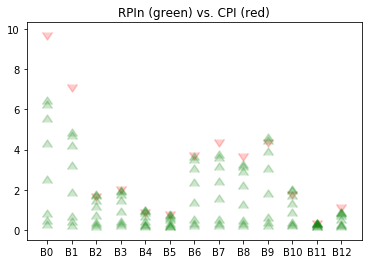

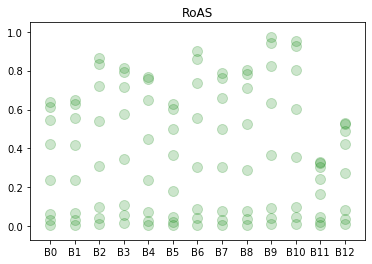

In [8]:
def scatterRoASRPICPI(df):
   

    lst = [1,3,7,30,60,90,120,k]
    
      
    for day in lst:        
        plt.title(label = "RPIn (green) vs. CPI (red)")
        dctRPI, dctCPI, dctRoAS, dctCPA, dctAVP = analizeRPICPI(df, day)        
        plt.scatter(dctRPI.keys(), dctRPI.values(), c='green', s=100, alpha=0.2, marker = matplotlib.markers.CARETUPBASE)
        
        if day == 1:
            plt.scatter(dctCPI.keys(), dctCPI.values(), c='red', s=100, alpha=0.2, marker = matplotlib.markers.CARETDOWNBASE)
        
    plt.show()
    
    for day in lst:        
        plt.title(label = "RoAS")
        dctRPI, dctCPI, dctRoAS, dctCPA, dctAVP = analizeRPICPI(df, day)  
        plt.scatter(dctRoAS.keys(), dctRoAS.values(), c='green', s=100, alpha=0.2, marker = 'o')
    
    plt.show()             
         
    
    return 

output_scatterRoASRPICPI = scatterRoASRPICPI(output_summRegBuy)

In [9]:
def lstlsRoAS(df):
    # метрики в разрезе сегментов и дней RoAS, CPA, day
    # выполняется несколько минут!
    
    lst = [1,3,7,30,60,90,120,k]
    
    for segment in segments:
        for day in lst:
            dctRPI, dctCPI, dctRoAS, dctCPA, dctAVP = analizeRPICPI(df, day)  
            print(segment, ':', 'RoAS', round(dctRoAS[segment],3), 'CPA', round(dctCPA[segment]), '-', day)
    return

output_lstlsRoAS = lstlsRoAS(output_summRegBuy)

B0 : RoAS 0.008 CPA 1395.0 - 1
B0 : RoAS 0.03 CPA 527.0 - 3
B0 : RoAS 0.065 CPA 347.0 - 7
B0 : RoAS 0.238 CPA 223.0 - 30
B0 : RoAS 0.421 CPA 199.0 - 60
B0 : RoAS 0.546 CPA 190.0 - 90
B0 : RoAS 0.616 CPA 186.0 - 120
B0 : RoAS 0.636 CPA 185.0 - 144
B1 : RoAS 0.008 CPA 1505.0 - 1
B1 : RoAS 0.032 CPA 508.0 - 3
B1 : RoAS 0.067 CPA 310.0 - 7
B1 : RoAS 0.235 CPA 190.0 - 30
B1 : RoAS 0.419 CPA 167.0 - 60
B1 : RoAS 0.556 CPA 159.0 - 90
B1 : RoAS 0.628 CPA 156.0 - 120
B1 : RoAS 0.648 CPA 155.0 - 144
B2 : RoAS 0.011 CPA 980.0 - 1
B2 : RoAS 0.041 CPA 254.0 - 3
B2 : RoAS 0.1 CPA 130.0 - 7
B2 : RoAS 0.308 CPA 69.0 - 30
B2 : RoAS 0.544 CPA 57.0 - 60
B2 : RoAS 0.721 CPA 53.0 - 90
B2 : RoAS 0.832 CPA 51.0 - 120
B2 : RoAS 0.863 CPA 51.0 - 144
B3 : RoAS 0.015 CPA 466.0 - 1
B3 : RoAS 0.056 CPA 155.0 - 3
B3 : RoAS 0.11 CPA 100.0 - 7
B3 : RoAS 0.345 CPA 66.0 - 30
B3 : RoAS 0.575 CPA 58.0 - 60
B3 : RoAS 0.714 CPA 55.0 - 90
B3 : RoAS 0.794 CPA 54.0 - 120
B3 : RoAS 0.813 CPA 54.0 - 144
B4 : RoAS 0.008 CPA 884.

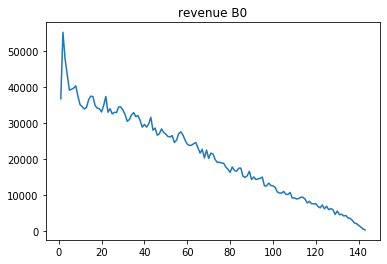

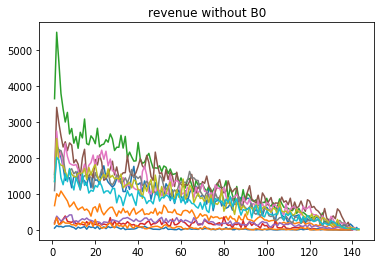

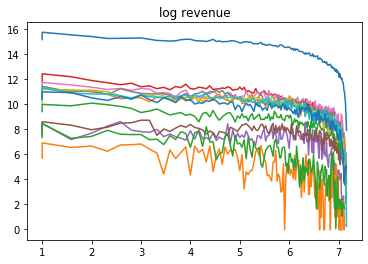

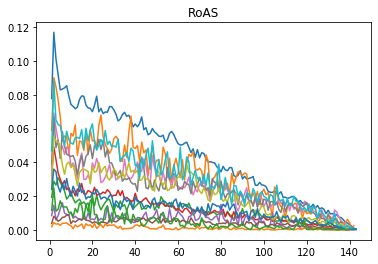

In [10]:
def scatterRevenueRoAS(df):   
    
    
    for segment in segments: 
        df_segment = df[df['feature_x'] == segment]
        df_segment = df_segment.groupby(by=['delta_day'])['revenue'].agg('sum').reset_index()
        x = df_segment[['delta_day']].values
        y = df_segment[['revenue']].values
        if segment == 'B0':
            plt.title(label='revenue B0')
            plt.plot(x,y)
            plt.show()
        else:
            plt.title(label='revenue without B0')
            plt.plot(x,y)
    plt.show()
    
    
    for segment in segments: 
        df_segment = df[df['feature_x'] == segment]
        df_segment = df_segment.groupby(by=['delta_day'])['revenue'].agg('sum').reset_index()
        df_segment['log_revenue'] = np.log2(df_segment['revenue']).fillna(1)
        df_segment['log_day'] = np.log2(df_segment['delta_day']).fillna(1)
        df_segment.loc[df_segment['log_revenue'] == 0, 'log_revenue'] = 1
        df_segment.loc[df_segment['log_day'] == 0, 'log_day'] = 1
        x = df_segment[['log_day']].values
        y = df_segment[['log_revenue']].values
        plt.title(label='log revenue')
        plt.plot(x,y)
    plt.show()
        
    
    for segment in segments: 
        df_segment = df[df['feature_x'] == segment]
        df_segment = df_segment.groupby(by=['delta_day'])['revenue'].agg('sum').reset_index()
        clients = len(users['id'][users['feature_x'] == segment].unique())
        x = df_segment[['delta_day']].values
        y = df_segment[['revenue']].values               
        plt.title(label='RoAS')
        plt.plot(x,y/clients)
        
    plt.show()
    
    return   
        
output_scatterRevenueRoAS = scatterRevenueRoAS(output_summRegBuy)    

## Модель с одной компонентой Revenue

In [11]:
def modelRev(df):
    
    dctPredRev = {}
    
    for segment in segments:
        df_segment = df[df['feature_x'] == segment]
        df_segment = df_segment.groupby(by=['delta_day'])['revenue'].agg('sum').reset_index()
        df_segment['log_day'] = np.log2(df_segment['delta_day']).fillna(1)  
        df_segment.loc[df_segment['log_day'] == 0, 'log_day'] = 1
        X = df_segment[['log_day']].values
        y = df_segment[['revenue']].values
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        dctPredRev[segment] = [model.intercept_, model.coef_]  

        
    return dctPredRev
        
dctPredRev = modelRev(output_summRegBuy)
dctPredRev  

{'B0': [array([71244.59678692]), array([[-8772.03479953]])],
 'B1': [array([2831.61299711]), array([[-340.79986008]])],
 'B2': [array([1269.52288053]), array([[-154.76519602]])],
 'B3': [array([5796.90935767]), array([[-758.05700855]])],
 'B4': [array([368.14401136]), array([[-38.74667259]])],
 'B5': [array([527.51283282]), array([[-56.80680937]])],
 'B6': [array([3915.13755399]), array([[-465.77439969]])],
 'B7': [array([3407.12094782]), array([[-410.85958551]])],
 'B8': [array([3140.22571097]), array([[-384.92328768]])],
 'B9': [array([2958.4431235]), array([[-361.04689447]])],
 'B10': [array([2483.5089649]), array([[-306.28045718]])],
 'B11': [array([150.76333974]), array([[-20.31799909]])],
 'B12': [array([322.09260498]), array([[-44.18661609]])]}

In [12]:
def comparasionRevenue(df):
    # сравнение предсказанных и реальных метрик: RoAS, RoAS_pred, RoAS_delta в разрезе сегментов и дней
    lst = [1,3,7,30,60,90,120,k]
    dct = {}    
    for segment in segments:
        clients = len(users['id'][users['feature_x'] == segment].unique())
        CPI = users['cpi'][users['feature_x'] == segment].sum() / clients
        for day in lst:      
            revenue = df['revenue'][ (df['delta_day'] <= day) & (df['feature_x'] == segment)].sum()               
            RPI = revenue / clients
            RoAS = RPI / CPI            
            revenue_sum_pred = 0
            
            a = dctPredRev[segment][0][0]
            b = dctPredRev[segment][1][0][0]
            RoAS_pred = 0
            for j in range(1, day+1):
          
                if j < 3:               
                    revenue_pred = (a + b*np.log2(j)) / 1.5 # калибровка модели
                else:
                    revenue_pred = a + b*np.log2(j)                    
                if revenue_pred > 0:                    
                    revenue_sum_pred += revenue_pred
                    RPI = (revenue_pred) / clients                
                    RoAS_pred += RPI / CPI 
                                           
            print(segment, j, 'RoAS', round(RoAS,3), 'RoAS_pred', round(RoAS_pred,3), 'RoAS_delta', round(( (RoAS_pred-RoAS) / RoAS) * 100,2), int(RoAS*clients), int(RoAS_pred * clients))
        print(segment, j, 'Выручка', int(revenue), 'Выручка_predict', int(revenue_sum_pred))
   
    return 

output_comparasionRevenue = comparasionRevenue(output_summRegBuy)  

B0 1 RoAS 0.008 RoAS_pred 0.01 RoAS_delta 29.61 3724 4827
B0 3 RoAS 0.03 RoAS_pred 0.032 RoAS_delta 5.04 14174 14888
B0 7 RoAS 0.065 RoAS_pred 0.075 RoAS_delta 15.1 30575 35192
B0 30 RoAS 0.238 RoAS_pred 0.248 RoAS_delta 4.18 111993 116674
B0 60 RoAS 0.421 RoAS_pred 0.397 RoAS_delta -5.67 198577 187314
B0 90 RoAS 0.546 RoAS_pred 0.505 RoAS_delta -7.5 257229 237946
B0 120 RoAS 0.616 RoAS_pred 0.585 RoAS_delta -5.02 290117 275541
B0 144 RoAS 0.636 RoAS_pred 0.633 RoAS_delta -0.44 299842 298521
B0 144 Выручка 2950083 Выручка_predict 2937082
B1 1 RoAS 0.008 RoAS_pred 0.01 RoAS_delta 22.65 212 260
B1 3 RoAS 0.032 RoAS_pred 0.031 RoAS_delta -4.51 844 806
B1 7 RoAS 0.067 RoAS_pred 0.073 RoAS_delta 9.01 1755 1913
B1 30 RoAS 0.235 RoAS_pred 0.245 RoAS_delta 4.16 6160 6416
B1 60 RoAS 0.419 RoAS_pred 0.398 RoAS_delta -5.2 10980 10409
B1 90 RoAS 0.556 RoAS_pred 0.51 RoAS_delta -8.3 14554 13346
B1 120 RoAS 0.628 RoAS_pred 0.596 RoAS_delta -5.2 16451 15594
B1 144 RoAS 0.648 RoAS_pred 0.65 RoAS_delta

In [13]:
def predictProfit365():
    # Прогноз выручки на 365 день: Выручка_365, Затраты, RoAS_365
    
    lst_pofit = []
    lst_loss = []
    dct_negative = {}
    for segment in segments:
        clients = len(users['id'][users['feature_x'] == segment].unique())
        CPI = users['cpi'][users['feature_x'] == segment].sum() / clients
        a = dctPredRev[segment][0][0]
        b = dctPredRev[segment][1][0][0]
        revenue_sum_pred = 0
        
        cnt_negative = 0
        for day in range(1,366):
            
            if day < 4:               
                revenue_pred = (a + b*np.log2(day))/1.5
            else:
                revenue_pred = a + b*np.log2(day)                    
            if revenue_pred > 0:                    
                revenue_sum_pred += revenue_pred                   
            else:
                cnt_negative +=1
                
        dct_negative[segment] = cnt_negative
    
        PRI_pred = revenue_sum_pred / clients
        RoAS_pred = PRI_pred / CPI
        
        print(segment, 'Выручка_365',  int(revenue_sum_pred), 'Затраты', int(CPI*clients),'RoAS_365', round(RoAS_pred,2))   
        if RoAS_pred > 1.0:
            print(f'Сегмент {segment} приносит прибыль')
            lst_pofit.append(segment)
            
        else:
            print(f'Сегмент {segment} убыточен')
            lst_loss.append(segment)
    print('Прибыльные сегменты RoAS[365]', lst_pofit)
    print('Убыточные  сегменты RoAS[365]',lst_loss)
    
    print('Количество дней в конце года с нулевой выручкой', dct_negative.items())
    
    return 

output_predictProfit365 = predictProfit365()

B0 Выручка_365 3414203 Затраты 4636846 RoAS_365 0.74
Сегмент B0 убыточен
B1 Выручка_365 151495 Затраты 189604 RoAS_365 0.8
Сегмент B1 убыточен
B2 Выручка_365 63814 Затраты 63692 RoAS_365 1.0
Сегмент B2 приносит прибыль
B3 Выручка_365 210168 Затраты 246744 RoAS_365 0.85
Сегмент B3 убыточен
B4 Выручка_365 33847 Затраты 25650 RoAS_365 1.32
Сегмент B4 приносит прибыль
B5 Выручка_365 45173 Затраты 44739 RoAS_365 1.01
Сегмент B5 приносит прибыль
B6 Выручка_365 221789 Затраты 191684 RoAS_365 1.16
Сегмент B6 приносит прибыль
B7 Выручка_365 180568 Затраты 186730 RoAS_365 0.97
Сегмент B7 убыточен
B8 Выручка_365 153734 Затраты 161766 RoAS_365 0.95
Сегмент B8 убыточен
B9 Выручка_365 147939 Затраты 130948 RoAS_365 1.13
Сегмент B9 приносит прибыль
B10 Выручка_365 118095 Затраты 107627 RoAS_365 1.1
Сегмент B10 приносит прибыль
B11 Выручка_365 4785 Затраты 13674 RoAS_365 0.35
Сегмент B11 убыточен
B12 Выручка_365 9468 Затраты 17673 RoAS_365 0.54
Сегмент B12 убыточен
Прибыльные сегменты RoAS[365] ['B2',

## Прибыльные сегменты 'B2', 'B4', 'B5', 'B6', 'B9', 'B10'
## Убыточные  сегменты 'B0', 'B1', 'B3', 'B7', 'B8', 'B11', 'B12'

## Параметры безубыточности

In [14]:
def zeroProfit():
    # визуализация затрат == выручки для безубытка
    for segment in segments:
        clients = len(users['id'][users['feature_x'] == segment].unique())
        CPI = users['cpi'][users['feature_x'] == segment].sum() / clients
        PRI = CPI
        RoAS = PRI / CPI
        
        revenue_segment = CPI*clients
        print(segment, revenue_segment)
    
    return

output_zeroProfit = zeroProfit()

B0 4636846.090000001
B1 189604.59
B2 63692.21
B3 246744.46500000005
B4 25650.33
B5 44739.380000000005
B6 191684.82000000004
B7 186730.06999999998
B8 161766.69999999998
B9 130948.45
B10 107627.3
B11 13674.869999999997
B12 17673.32


In [15]:
def predFirst():
    lst = [1,3,7,30]
    dct_revenue_sum_pred = {}
    dct_negative = {}
    dct_days_revenue = {}
    SoAR_sum_pred = {}
    
    for segment in segments:
        clients = len(users['id'][users['feature_x'] == segment].unique())
        CPI = users['cpi'][users['feature_x'] == segment].sum() / clients
        zero_profit = CPI*clients
        
        a = dctPredRev[segment][0][0]
        b = dctPredRev[segment][1][0][0]
        
        
        revenue_sum_pred = 0
        
        cnt_negative = 0
        for day in range(1,366):
            
            if day < 4:               
                revenue_pred = (a + b*np.log2(day))/1.5
            else:
                revenue_pred = a + b*np.log2(day)                    
            if revenue_pred > 0:                    
                revenue_sum_pred += revenue_pred                   
            else:
                cnt_negative +=1
                
        dct_negative[segment] = cnt_negative
        dct_revenue_sum_pred[segment] = revenue_sum_pred / zero_profit
        
        for day in lst:
            
            revenue_sum_pred = 0
            
            for i in range(1, day+1):                
                
                if i < 4:               
                    revenue_pred = (a + b*np.log2(i))/1.5
                else:
                    revenue_pred = a + b*np.log2(i)                    
                if revenue_pred > 0:                    
                    revenue_sum_pred += revenue_pred / dct_revenue_sum_pred[segment]
                
            if dct_days_revenue.get(segment, None):
                dct_days_revenue[segment] = [dct_days_revenue[segment], revenue_sum_pred]
            else:
                dct_days_revenue[segment] =  revenue_sum_pred
                
            
            SoAR = revenue_sum_pred / clients / CPI
            
            if SoAR_sum_pred.get(segment, None):
                SoAR_sum_pred[segment] = [SoAR_sum_pred[segment], SoAR]
            else:
                SoAR_sum_pred[segment] =  SoAR 
                        
                    
        
    return dct_revenue_sum_pred, dct_days_revenue, SoAR_sum_pred

    
    
dct_revenue_sum_pred, dct_days_revenue, SoAR_sum_pred = predFirst()

## Прогноз RoAS и Revenue [1,3,7,30] при условии RoAS[365] =1

In [16]:
def describezeroprofit():
    # прогнох RoAS, Revenue для безубыточности в разрезе сегментов на 1,3,7,30 дней
    for segment in segments:       
        
        print('RoAS', segment, '1 день:', round(SoAR_sum_pred[segment][0][0][0], 3), '3 дня:', round(SoAR_sum_pred[segment][0][0][1],3),
              '7 дней:', round(SoAR_sum_pred[segment][0][1],3), '30 дней:', round(SoAR_sum_pred[segment][1]),3)
        
        
        
        print('Revenue',segment, '1 день:', int(dct_days_revenue[segment][0][0][0]), '3 дня:', int(dct_days_revenue[segment][0][0][1]),
              '7 дней:', int(dct_days_revenue[segment][0][1]), '30 дней:', int(dct_days_revenue[segment][1]))
        
        
        
        
    return
        
output_describezeroprofit = describezeroprofit()

RoAS B0 1 день: 0.014 3 дня: 0.037 7 дней: 0.096 30 дней: 0.0 3
Revenue B0 1 день: 64505 3 дня: 172984 7 дней: 444286 30 дней: 1533061
RoAS B1 1 день: 0.012 3 дня: 0.034 7 дней: 0.086 30 дней: 0.0 3
Revenue B1 1 день: 2362 3 дня: 6352 7 дней: 16385 30 дней: 57199
RoAS B2 1 день: 0.013 3 дня: 0.036 7 дней: 0.092 30 дней: 0.0 3
Revenue B2 1 день: 844 3 дня: 2267 7 дней: 5835 30 дней: 20240
RoAS B3 1 день: 0.018 3 дня: 0.049 7 дней: 0.124 30 дней: 0.0 3
Revenue B3 1 день: 4537 3 дня: 12077 7 дней: 30655 30 дней: 102274
RoAS B4 1 день: 0.007 3 дня: 0.02 7 дней: 0.052 30 дней: 0.0 3
Revenue B4 1 день: 185 3 дня: 507 7 дней: 1338 30 дней: 4953
RoAS B5 1 день: 0.008 3 дня: 0.021 7 дней: 0.056 30 дней: 0.0 3
Revenue B5 1 день: 348 3 дня: 947 7 дней: 2491 30 дней: 9139
RoAS B6 1 день: 0.012 3 дня: 0.032 7 дней: 0.082 30 дней: 0.0 3
Revenue B6 1 день: 2255 3 дня: 6073 7 дней: 15698 30 дней: 55116
RoAS B7 1 день: 0.013 3 дня: 0.034 7 дней: 0.087 30 дней: 0.0 3
Revenue B7 1 день: 2348 3 дня: 6314 

## Модель с двумя компонентами C2P и AVP

In [17]:
def modelRPIC2P(df):
    
    dctAVP = {} # средний чек
    dctClients = {} # количество покупателей
    
    for segment in segments:
        
        df_segment = df[df['feature_x'] == segment]      
        df_day = df_segment.groupby(by=['delta_day'])['revenue'].agg('sum').reset_index()
        df_clients = df_segment.groupby(by=['delta_day'])['id'].nunique().reset_index()
                
        df_revenue = df_day.merge(df_clients, how='left', on='delta_day')
        df_revenue = df_revenue.rename(columns={'id':'clients'})
        df_revenue['AVP'] = df_revenue['revenue'] / df_revenue['clients']              
        df_revenue['log_day'] = np.log2(df_revenue['delta_day']).fillna(1)    
        df_revenue.loc[df_revenue['log_day'] == 0, 'log_day'] = 1
        
               
        #y = pd.DataFrame(np.c_[df_revenue['RPI'], df_revenue['clients']], columns=['RPI','clients'])
        
        #model1 predict Average Price
        X1 = df_revenue[['log_day']].values 
        y1 = df_revenue[['AVP']].values
        
        X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.33, random_state=42)
        model1 = LinearRegression().fit(X_train1, y_train1)
        
        #model1 predict Average Clients
        X2 = df_revenue[['log_day']].values 
        y2 = df_revenue[['clients']].values
       
        X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.33, random_state=42)
        model2 = LinearRegression().fit(X_train2, y_train2) 
        
        
        dctAVP[segment] = [model1.intercept_, model1.coef_]  
        dctClients[segment] = [model2.intercept_, model2.coef_] 

        
    return dctAVP, dctClients
        
dctAVP, dctClients = modelRPIC2P(output_summRegBuy)


In [18]:
def comparasionRPIC2P(df):
    lst = [1,3,7,30,60,90,120, k]
    dct = {}    
    for segment in segments:
        clients = len(users['id'][users['feature_x'] == segment].unique())
        CPI = users['cpi'][users['feature_x'] == segment].sum() / clients
        for n in lst:      
            revenue = df['revenue'][ (df['delta_day'] <= n) & (df['feature_x'] == segment)].sum()               
            RPI = revenue / clients
            RoAS = RPI / CPI            
            revenue_sum_pred = 0
            
            a = dctPredRev[segment][0][0]
            b = dctPredRev[segment][1][0][0]
            RoAS_pred = 0
            for j in range(1, n+1):
          
                if j < 3:               
                    revenue_pred = (a + b*np.log2(j))/1.5
                else:
                    revenue_pred = a + b*np.log2(j)                    
                if revenue_pred > 0:                    
                    revenue_sum_pred += revenue_pred
                    RPI = (revenue_pred) / clients                
                    RoAS_pred += RPI / CPI 
                                           
            print(segment, 'RoAS', round(RoAS,3), 'RoAS_pred', round(RoAS_pred,3), 'RoAS_delta', round(( (RoAS_pred-RoAS) / RoAS) * 100,3), int(RoAS*clients), int(RoAS_pred * clients))
        print(segment, 'Выручка', int(revenue), 'Выручка_predict', int(revenue_sum_pred))
   
    return 

output_comparasionRPIC2P = comparasionRPIC2P(output_summRegBuy)  

B0 RoAS 0.008 RoAS_pred 0.01 RoAS_delta 29.61 3724 4827
B0 RoAS 0.03 RoAS_pred 0.032 RoAS_delta 5.037 14174 14888
B0 RoAS 0.065 RoAS_pred 0.075 RoAS_delta 15.099 30575 35192
B0 RoAS 0.238 RoAS_pred 0.248 RoAS_delta 4.18 111993 116674
B0 RoAS 0.421 RoAS_pred 0.397 RoAS_delta -5.672 198577 187314
B0 RoAS 0.546 RoAS_pred 0.505 RoAS_delta -7.496 257229 237946
B0 RoAS 0.616 RoAS_pred 0.585 RoAS_delta -5.024 290117 275541
B0 RoAS 0.636 RoAS_pred 0.633 RoAS_delta -0.441 299842 298521
B0 Выручка 2950083 Выручка_predict 2937082
B1 RoAS 0.008 RoAS_pred 0.01 RoAS_delta 22.646 212 260
B1 RoAS 0.032 RoAS_pred 0.031 RoAS_delta -4.515 844 806
B1 RoAS 0.067 RoAS_pred 0.073 RoAS_delta 9.005 1755 1913
B1 RoAS 0.235 RoAS_pred 0.245 RoAS_delta 4.156 6160 6416
B1 RoAS 0.419 RoAS_pred 0.398 RoAS_delta -5.197 10980 10409
B1 RoAS 0.556 RoAS_pred 0.51 RoAS_delta -8.299 14554 13346
B1 RoAS 0.628 RoAS_pred 0.596 RoAS_delta -5.204 16451 15594
B1 RoAS 0.648 RoAS_pred 0.65 RoAS_delta 0.311 16966 17019
B1 Выручка 12

## Метрики Roas находятся аналогичным способом как и в однокомпонентной модели с единственным отличием: в однокомпонетной модели Revenue                                    задавалась a+x* log2(day), а вдухкомпонентной a1 + x1* log2(day) + a2 + x2* log2(day). Параметры x1, x2 сохранены в dctAVP и dctClients из функции "modelRPIC2P"


In [19]:
dctAVP

{'B0': [array([12.16735938]), array([[-0.23072907]])],
 'B1': [array([8.02764332]), array([[0.60722745]])],
 'B2': [array([5.81812729]), array([[-0.04816102]])],
 'B3': [array([6.6296605]), array([[0.03736796]])],
 'B4': [array([6.19938746]), array([[0.40550172]])],
 'B5': [array([4.54484005]), array([[0.02975206]])],
 'B6': [array([10.49622366]), array([[0.01966529]])],
 'B7': [array([11.52063315]), array([[-0.21346735]])],
 'B8': [array([8.71999806]), array([[-0.02802446]])],
 'B9': [array([9.70524681]), array([[0.09149661]])],
 'B10': [array([12.04393203]), array([[-0.41689522]])],
 'B11': [array([7.43549467]), array([[-0.52813756]])],
 'B12': [array([14.59276378]), array([[-1.12507884]])]}

In [20]:
dctClients

{'B0': [array([6409.96138801]), array([[-788.75618923]])],
 'B1': [array([274.25265872]), array([[-33.79244635]])],
 'B2': [array([211.34114252]), array([[-24.60395512]])],
 'B3': [array([881.32748862]), array([[-116.39195023]])],
 'B4': [array([56.79238396]), array([[-6.84737446]])],
 'B5': [array([117.66674215]), array([[-13.11326289]])],
 'B6': [array([371.05723807]), array([[-44.28843801]])],
 'B7': [array([315.02098064]), array([[-37.35440399]])],
 'B8': [array([368.63886194]), array([[-45.42052163]])],
 'B9': [array([299.30312165]), array([[-36.94606442]])],
 'B10': [array([229.0325583]), array([[-27.21385795]])],
 'B11': [array([26.1017203]), array([[-3.35504027]])],
 'B12': [array([31.72971408]), array([[-4.19027882]])]}